In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 44.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.decomposition import PCA

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [37]:
(X_train, y_train), (X_test, y_test) = tfk.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=len(X_test), stratify=y_train)

In [38]:
def introduce_noise(data):
  noise_factor = 0.1
  noisy_array = data + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=data.shape
    )

  return np.clip(noisy_array, 0.0, 1.0)

In [27]:
print(y_train.shape)

(50000,)


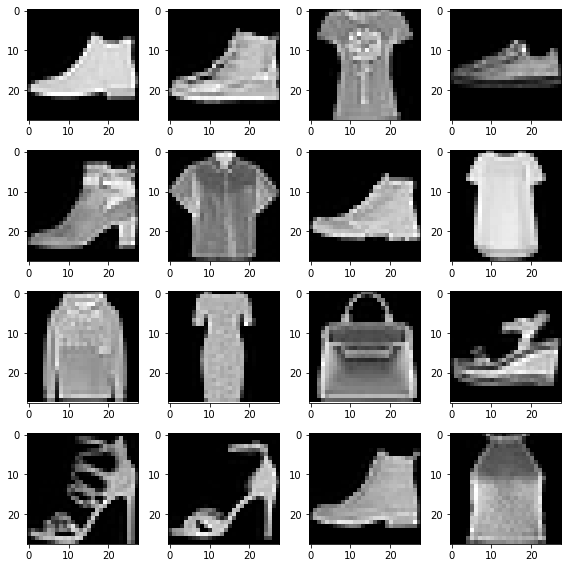

In [34]:
# Inspect the data
num_row = 4
num_col = 4
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.squeeze(X_train[i]), cmap='gray')
plt.tight_layout()
plt.show()

In [39]:
X_train = (np.expand_dims(X_train, axis=-1)/255.).astype(np.float32)
print('Data shape', X_train.shape)
print('Data mean: ' + str(X_train.mean()))
print('Data std: ' + str(X_train.std()))

Data shape (50000, 28, 28, 1)
Data mean: 0.28627566
Data std: 0.3531854


In [40]:
X_val = (np.expand_dims(X_val, axis=-1)/255.).astype(np.float32)
print('Data shape', X_val.shape)
print('Data mean: ' + str(X_val.mean()))
print('Data std: ' + str(X_val.std()))

Data shape (10000, 28, 28, 1)
Data mean: 0.28486446
Data std: 0.3522155


In [41]:
X_test = (np.expand_dims(X_test, axis=-1)/255.).astype(np.float32)
print('Data shape', X_test.shape)
print('Data mean: ' + str(X_test.mean()))
print('Data std: ' + str(X_test.std()))

Data shape (10000, 28, 28, 1)
Data mean: 0.28684944
Data std: 0.3524442


In [42]:
X_train_noisy= introduce_noise(X_train)
X_test__noisy = introduce_noise(X_test)
X_val__noisy = introduce_noise(X_val)


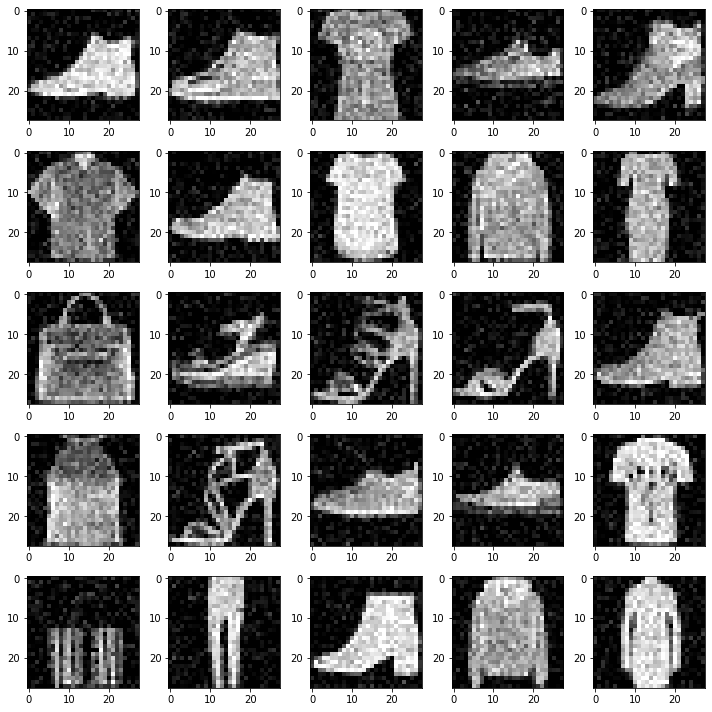

In [43]:
# Inspect the data
num_row = 5
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.squeeze(X_train_noisy[i]), cmap='gray')
plt.tight_layout()
plt.show()

In [44]:
input_shape = X_train.shape[1:]
print(input_shape)

(28, 28, 1)


In [45]:
latent_dim = 2

### Autoencoder

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 32, 32, 1)        0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       1280      
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         2951

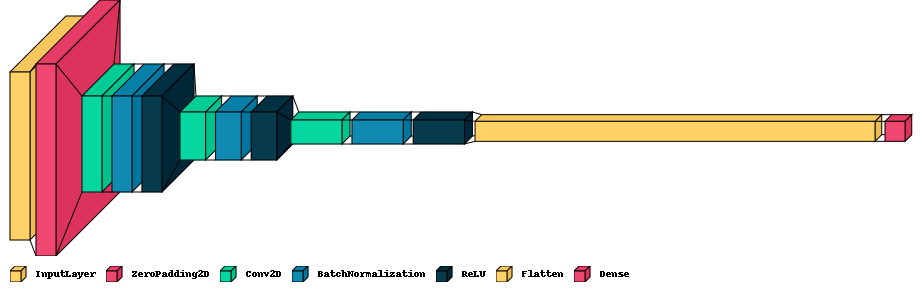

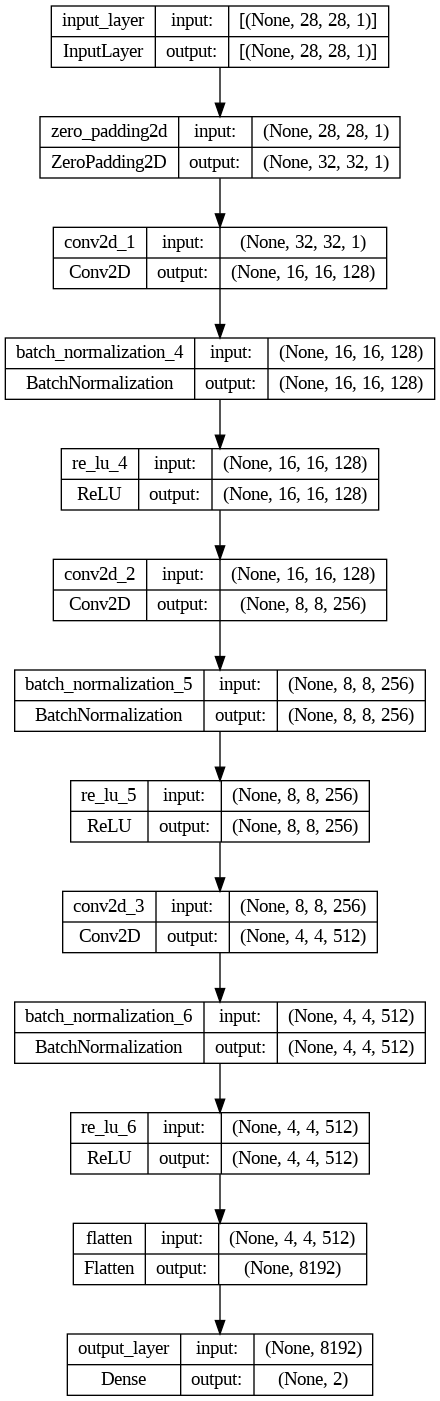

In [48]:
def get_encoder(enc_input_shape=input_shape, enc_output_shape=latent_dim, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=enc_input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2))(input_layer)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(512, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Flatten()(x)
    output_layer = tfkl.Dense(enc_output_shape, name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')

    # Return the discriminator
    return model
encoder = get_encoder(input_shape)
encoder.summary()
display(visualkeras.layered_view(encoder, legend=True, scale_xy=6))
tfk.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder.png')

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 8192)              24576     
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1179904   
 nspose)                                                   

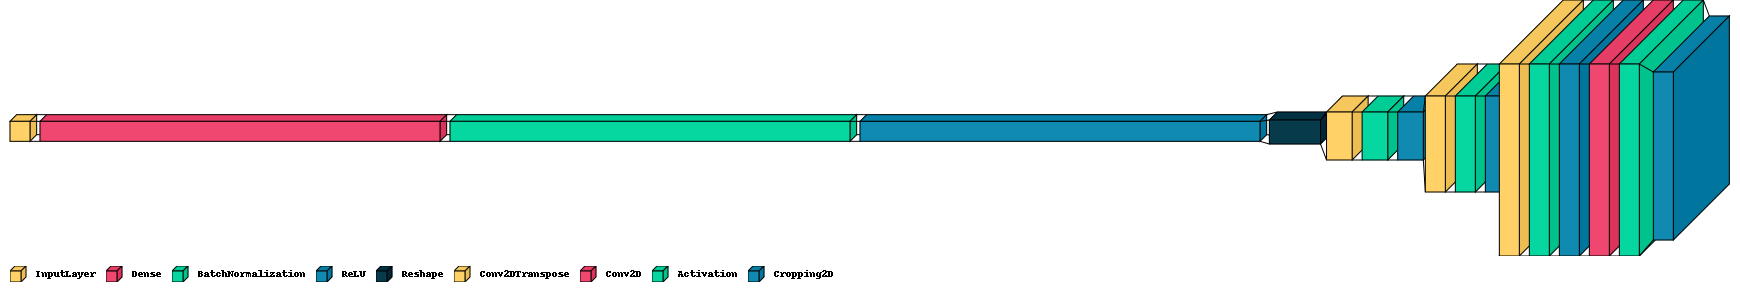

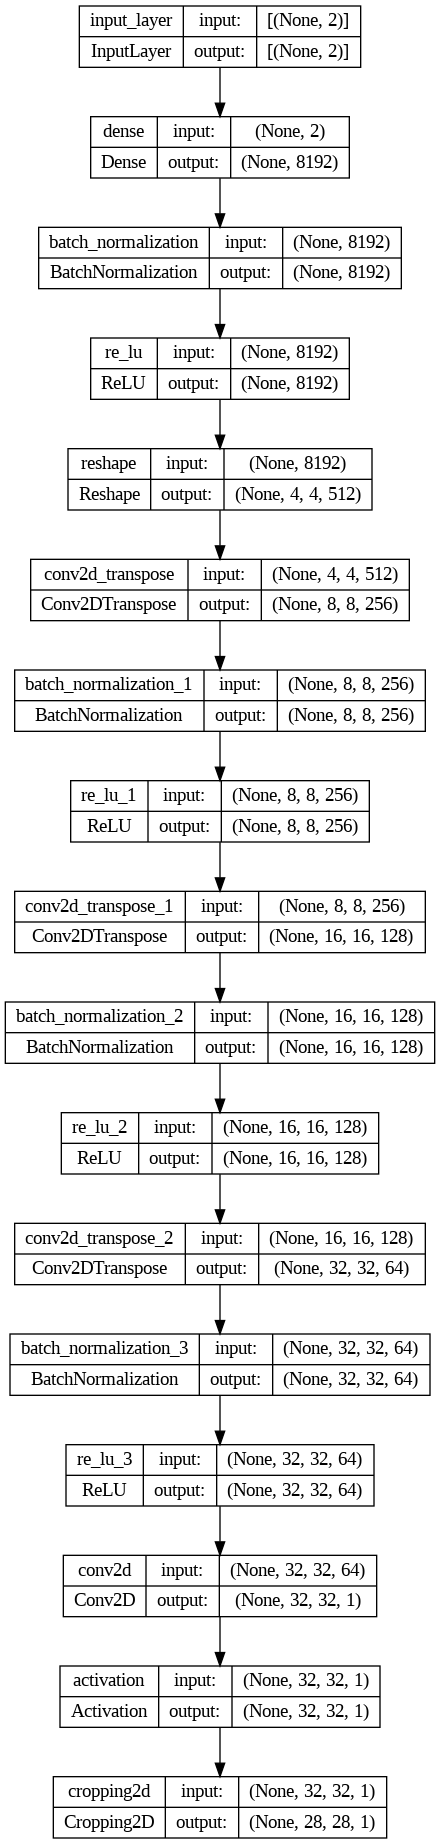

In [46]:
def get_decoder(dec_input_shape=latent_dim, dec_output_shape=input_shape, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=dec_input_shape, name='input_layer')
    x = tfkl.Dense(4*4*512)(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Reshape((4,4,512))(x)

    x = tfkl.Conv2DTranspose(256, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2DTranspose(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2DTranspose(64, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(dec_output_shape[-1], 3, padding='same')(x)
    x = tfkl.Activation('sigmoid')(x)
    output_layer = tfkl.Cropping2D((2,2))(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='decoder')

    # Return the discriminator
    return model
decoder = get_decoder()
decoder.summary()
display(visualkeras.layered_view(decoder, legend=True, scale_xy=6))
tfk.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder.png')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 1496578   
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         1608449   
                                                                 
Total params: 3,105,027
Trainable params: 3,085,955
Non-trainable params: 19,072
_________________________________________________________________


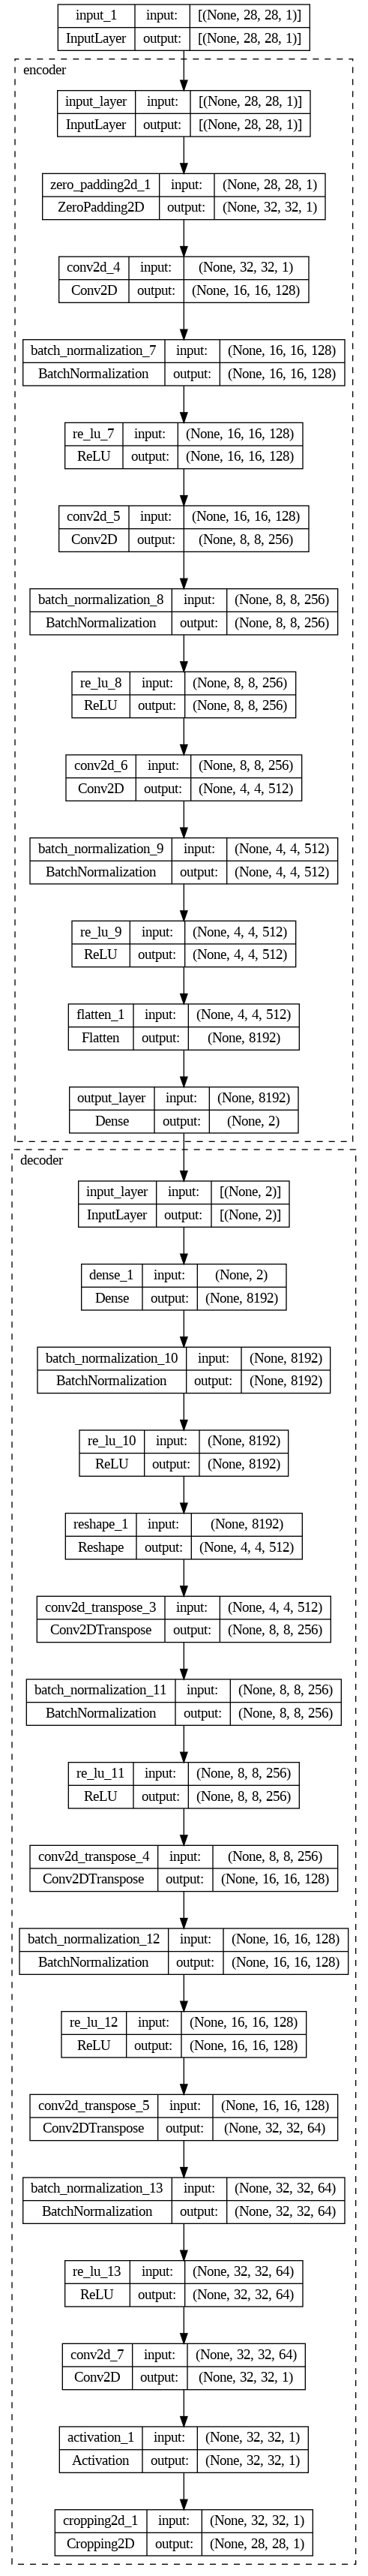

In [49]:
def get_autoencoder(ae_input_shape=input_shape, ae_output_shape=input_shape):
    tf.random.set_seed(seed)
    
    encoder = get_encoder()
    decoder = get_decoder()

    input_layer = tfkl.Input(shape=ae_input_shape)
    z = encoder(input_layer)
    output_layer = decoder(z)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
    return model
autoencoder = get_autoencoder()
autoencoder.summary()
tfk.utils.plot_model(autoencoder, show_shapes=True, expand_nested=True, to_file='autoencoder.png')

In [50]:
learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)
autoencoder.compile(optimizer=optimizer, loss=tfk.losses.binary_crossentropy, metrics=['mse', 'mae'])

batch_size = 128
epochs = 1000

In [51]:
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val,X_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

Epoch 1/1000
391/391 [==============================] - 28s 49ms/step - loss: 0.3553 - mse: 0.0386 - mae: 0.1204 - val_loss: 0.4853 - val_mse: 0.0864 - val_mae: 0.2127 - lr: 0.0010
Epoch 2/1000
391/391 [==============================] - 18s 46ms/step - loss: 0.3398 - mse: 0.0335 - mae: 0.1083 - val_loss: 0.3643 - val_mse: 0.0419 - val_mae: 0.1191 - lr: 0.0010
Epoch 3/1000
391/391 [==============================] - 18s 47ms/step - loss: 0.3369 - mse: 0.0326 - mae: 0.1060 - val_loss: 0.3625 - val_mse: 0.0421 - val_mae: 0.1209 - lr: 0.0010
Epoch 4/1000
391/391 [==============================] - 19s 48ms/step - loss: 0.3341 - mse: 0.0317 - mae: 0.1038 - val_loss: 0.3317 - val_mse: 0.0309 - val_mae: 0.1019 - lr: 0.0010
Epoch 5/1000
391/391 [==============================] - 19s 48ms/step - loss: 0.3332 - mse: 0.0314 - mae: 0.1031 - val_loss: 0.3373 - val_mse: 0.0329 - val_mae: 0.1045 - lr: 0.0010
Epoch 6/1000
391/391 [==============================] - 20s 50ms/step - loss: 0.3322 - mse: 0.0

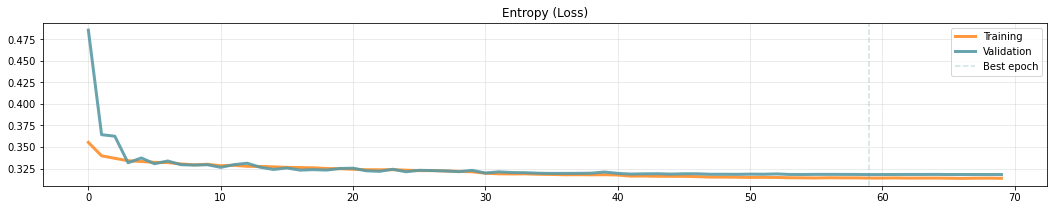

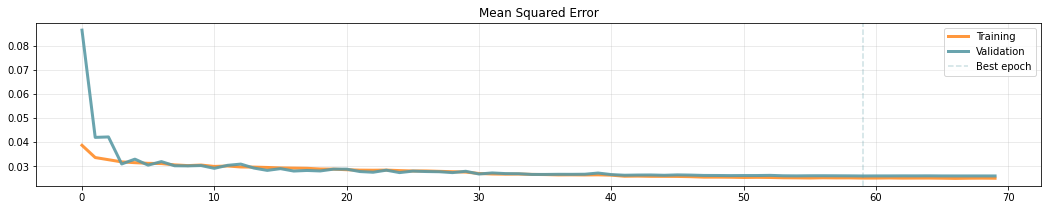

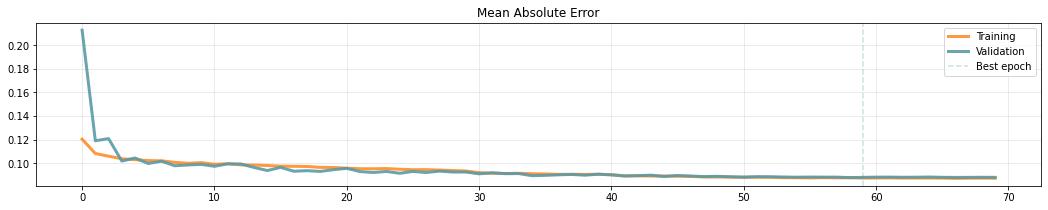

In [52]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mse'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_mse'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mae'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_mae'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()



In [53]:
autoencoder.save('autoencoder_latent2')

In [54]:
autoencoder_latent2 = tfk.models.load_model('autoencoder_latent2')
encoder_latent2 = autoencoder_latent2.get_layer('encoder')
decoder_latent2 = autoencoder_latent2.get_layer('decoder')


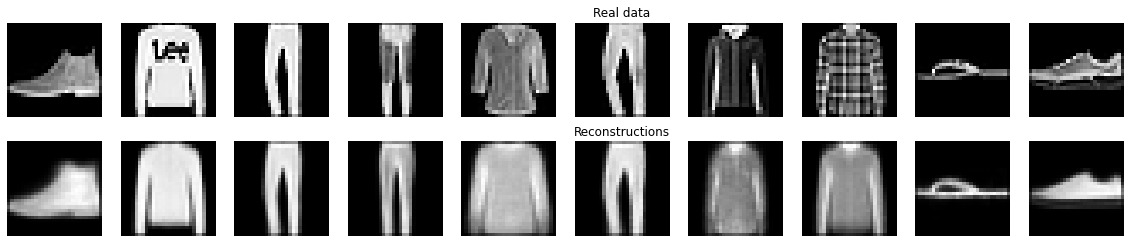

Entropy: 0.32065272
MSE: 0.02604917
MAE: 0.08876201


In [55]:
def get_reconstructions(model, X, imgs=10, verbose=True):
    predictions = model.predict(X, verbose=0)
    fig, axs = plt.subplots(2, imgs, figsize=(imgs*2, 4))
    for i in range(imgs):
        axs[0, i].imshow(np.squeeze(X[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i].axis('off')
        axs[1, i].imshow(np.squeeze(predictions[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i+imgs].axis('off')
    axs[0,imgs//2].set_title('Real data')
    axs[1,imgs//2].set_title('Reconstructions')
    plt.show()
    if verbose:
        entropy_score = np.mean(tfk.losses.binary_crossentropy(X, predictions))
        mse_score = np.mean(tfk.losses.mean_squared_error(X, predictions))
        mae_score = np.mean(tfk.losses.mean_absolute_error(X, predictions))
        print('Entropy:',entropy_score)
        print('MSE:',mse_score)
        print('MAE:',mae_score)

#get_reconstructions(autoencoder_latent16, X_test)
get_reconstructions(autoencoder_latent2, X_test)

#### Now we retrain using the noisy data

In [56]:
noisy_autoencoder = get_autoencoder()

In [57]:
learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)
noisy_autoencoder.compile(optimizer=optimizer, loss=tfk.losses.binary_crossentropy, metrics=['mse', 'mae'])

batch_size = 128
epochs = 1000

In [58]:
history = noisy_autoencoder.fit(
    X_train_noisy,
    X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val__noisy,X_val),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

Epoch 1/1000
391/391 [==============================] - 21s 50ms/step - loss: 0.3520 - mse: 0.0377 - mae: 0.1178 - val_loss: 0.4319 - val_mse: 0.0695 - val_mae: 0.1816 - lr: 0.0010
Epoch 2/1000
391/391 [==============================] - 21s 53ms/step - loss: 0.3370 - mse: 0.0327 - mae: 0.1065 - val_loss: 0.3571 - val_mse: 0.0388 - val_mae: 0.1117 - lr: 0.0010
Epoch 3/1000
391/391 [==============================] - 21s 54ms/step - loss: 0.3345 - mse: 0.0319 - mae: 0.1044 - val_loss: 0.3380 - val_mse: 0.0332 - val_mae: 0.1041 - lr: 0.0010
Epoch 4/1000
391/391 [==============================] - 19s 49ms/step - loss: 0.3325 - mse: 0.0312 - mae: 0.1027 - val_loss: 0.3294 - val_mse: 0.0301 - val_mae: 0.0995 - lr: 0.0010
Epoch 5/1000
391/391 [==============================] - 19s 49ms/step - loss: 0.3317 - mse: 0.0310 - mae: 0.1022 - val_loss: 0.3398 - val_mse: 0.0336 - val_mae: 0.1054 - lr: 0.0010
Epoch 6/1000
391/391 [==============================] - 19s 49ms/step - loss: 0.3306 - mse: 0.0

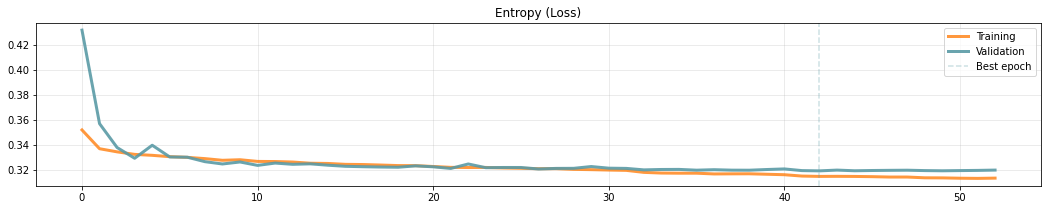

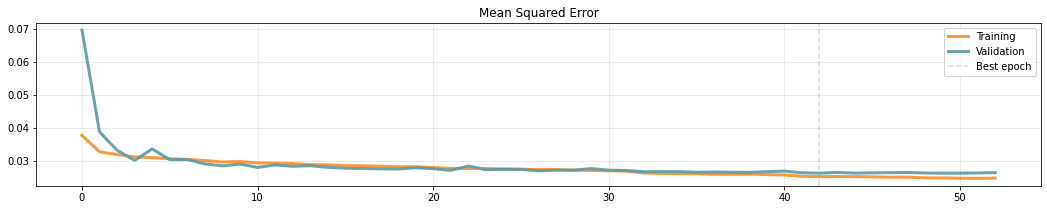

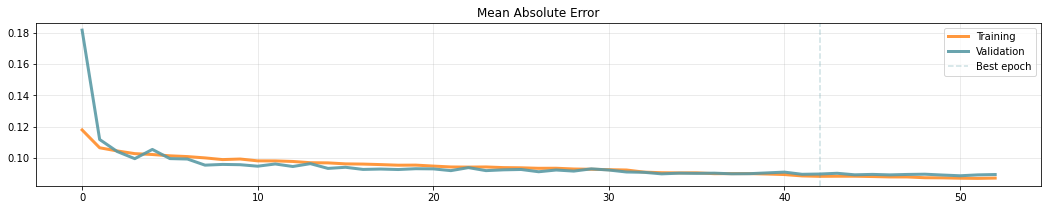

In [59]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mse'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_mse'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mae'], label='Training', alpha=.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_mae'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()



In [60]:
noisy_autoencoder.save('autoencoder_latent2_noise')

In [61]:
autoencoder_latent2_noise = tfk.models.load_model('autoencoder_latent2_noise')
encoder_latent2_noise = autoencoder_latent2_noise.get_layer('encoder')
decoder_latent2_noise = autoencoder_latent2_noise.get_layer('decoder')


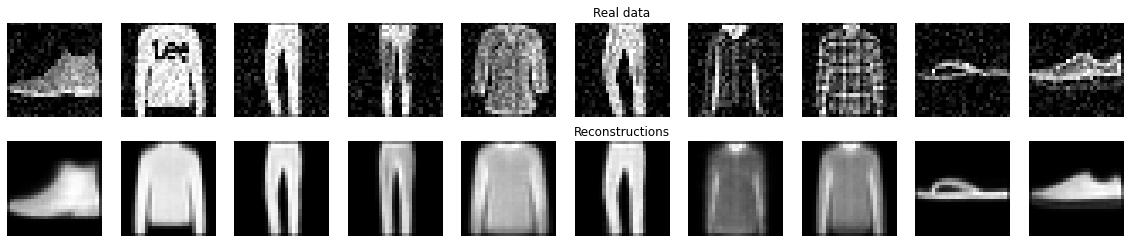

Entropy: 0.50426215
MSE: 0.03090348
MAE: 0.113751344


In [65]:
def get_reconstructions(model, X, imgs=10, verbose=True):
    predictions = model.predict(X, verbose=0)
    fig, axs = plt.subplots(2, imgs, figsize=(imgs*2, 4))
    for i in range(imgs):
        axs[0, i].imshow(np.squeeze(X[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i].axis('off')
        axs[1, i].imshow(np.squeeze(predictions[i]), cmap=plt.get_cmap('gray'))
        axs.flat[i+imgs].axis('off')
    axs[0,imgs//2].set_title('Real data')
    axs[1,imgs//2].set_title('Reconstructions')
    plt.show()
    if verbose:
        entropy_score = np.mean(tfk.losses.binary_crossentropy(X, predictions))
        mse_score = np.mean(tfk.losses.mean_squared_error(X, predictions))
        mae_score = np.mean(tfk.losses.mean_absolute_error(X, predictions))
        print('Entropy:',entropy_score)
        print('MSE:',mse_score)
        print('MAE:',mae_score)

#get_reconstructions(autoencoder_latent16, X_test)
get_reconstructions(autoencoder_latent2_noise, X_test__noisy)